In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob

In [3]:
import matplotlib.dates as dates
from scipy import stats
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
from scipy.signal import chirp, find_peaks, peak_widths
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
label_fontsize = 16 
title_fontsize = 18

In [5]:
import matplotlib.gridspec as gridspec

In [6]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
from tabulate import tabulate

In [7]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [8]:
label_fontsize = 16 
title_fontsize = 18

In [9]:
#ignore future deprecation related warnings..
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
basefolderdir = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
inputfolderpath = basefolderdir + "drosSleepStages_SciAdvances2023/data/dlc_data/"

In [11]:
inputfolderpath

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/'

In [12]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_bandpass_filt(data, cutoff1,cutoff2, fs, order=5):
    b, a = butter_lowpass(cutoff1, fs, order=order)
    y = filtfilt(b, a, data)
    #b, a = butter_highpass(cutoff2, fs, order=order)
    #y = filtfilt(b, a, y)
    return y

In [13]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    y_smooth = np.pad(y_smooth,(2,2),mode = 'constant',constant_values = (y_smooth[0],y_smooth[-1]))
    return y_smooth

In [14]:
def getposes(hour,posefiledlcname):
     
    hourindex = int(hour)-1
    poseresults_file = posefiledlcname[hourindex] #posefiles_dir + h5filename
    #print('\nprocessing: ', poseresults_file)
    dlc_df = pd.read_hdf(poseresults_file)
    
    proboscis_df = dlc_df.xs('proboscis', level='bodyparts', axis=1)
    proboscis_df.columns = proboscis_df.columns.droplevel()
    
    eye_df = dlc_df.xs('eye', level='bodyparts', axis=1)
    eye_df.columns = eye_df.columns.droplevel()
    
    leg1tip_df = dlc_df.xs('leg1_joint', level='bodyparts', axis=1)
    leg1tip_df.columns = leg1tip_df.columns.droplevel()
    
    leg1joint_df = dlc_df.xs('leg1_tip', level='bodyparts', axis=1)
    leg1joint_df.columns = leg1joint_df.columns.droplevel()
    
    abdomen_df = dlc_df.xs('abdomen', level='bodyparts', axis=1)
    abdomen_df.columns = abdomen_df.columns.droplevel()
    
    return proboscis_df,eye_df,leg1tip_df,leg1joint_df,abdomen_df

In [15]:
def computefeatures(hour,posefiledlcname):
    
    proboscis_df,eye_df,leg1tip_df,leg1joint_df,abdomen_df = getposes(hour,posefiledlcname)
    
    
    #proboscis related stuff..
    proboscis_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(proboscis_df.likelihood,cutoff1, cutoff2,fs)
    proboscis_df.loc[:,'x_filt'] = butter_bandpass_filt(proboscis_df.x, cutoff1, cutoff2,fs)
    proboscis_df.loc[:,'y_filt'] = butter_bandpass_filt(proboscis_df.y, cutoff1, cutoff2, fs)
    
    proboscis_df.loc[:,'likelihood_filtmov'] = np.convolve(proboscis_df.likelihood_filt, 
                                                           np.ones((nsamp,))/nsamp, mode='same')
    proboscis_df.loc[:,'x_filtmov'] = np.convolve(proboscis_df.x_filt, 
                                                  np.ones((nsamp,))/nsamp, mode='same')
    proboscis_df.loc[:,'y_filtmov'] = np.convolve(proboscis_df.y_filt, 
                                              np.ones((nsamp,))/nsamp, mode='same')
    
    #eye related stuff..
    eye_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(eye_df.likelihood, cutoff1, cutoff2,fs)
    eye_df.loc[:,'x_filt'] = butter_bandpass_filt(eye_df.x, cutoff1, cutoff2,fs)
    eye_df.loc[:,'y_filt'] = butter_bandpass_filt(eye_df.y, cutoff1, cutoff2,fs)
    
    eye_df.loc[:,'likelihood_filtmov'] = np.convolve(eye_df.likelihood_filt, 
                                                     np.ones((nsamp,))/nsamp, mode='same')
    eye_df.loc[:,'x_filtmov'] = np.convolve(eye_df.x_filt, 
                                            np.ones((nsamp,))/nsamp, mode='same')
    eye_df.loc[:,'y_filtmov'] = np.convolve(eye_df.y_filt, 
                                            np.ones((nsamp,))/nsamp, mode='same')
    
    #leg1tip related stuff..
    leg1tip_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(leg1tip_df.likelihood, cutoff1, cutoff2,fs)
    leg1tip_df.loc[:,'x_filt'] = butter_bandpass_filt(leg1tip_df.x, cutoff1, cutoff2,fs)
    leg1tip_df.loc[:,'y_filt'] = butter_bandpass_filt(leg1tip_df.y, cutoff1, cutoff2,fs)
    
    leg1tip_df.loc[:,'likelihood_filtmov'] = np.convolve(leg1tip_df.likelihood_filt, 
                                                         np.ones((nsamp,))/nsamp, mode='same')
    leg1tip_df.loc[:,'x_filtmov'] = np.convolve(leg1tip_df.x_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    leg1tip_df.loc[:,'y_filtmov'] = np.convolve(leg1tip_df.y_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    
    
    #leg1joint related stuff..
    leg1joint_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(leg1joint_df.likelihood, cutoff1, cutoff2,fs)
    leg1joint_df.loc[:,'x_filt'] = butter_bandpass_filt(leg1joint_df.x, cutoff1, cutoff2,fs)
    leg1joint_df.loc[:,'y_filt'] = butter_bandpass_filt(leg1joint_df.y, cutoff1, cutoff2,fs)
    
    leg1joint_df.loc[:,'likelihood_filtmov'] = np.convolve(leg1joint_df.likelihood_filt, 
                                                           np.ones((nsamp,))/nsamp, mode='same')
    leg1joint_df.loc[:,'x_filtmov'] = np.convolve(leg1joint_df.x_filt, 
                                              np.ones((nsamp,))/nsamp, mode='same')
    leg1joint_df.loc[:,'y_filtmov'] = np.convolve(leg1joint_df.y_filt, 
                                              np.ones((nsamp,))/nsamp, mode='same')
    
    #abdomen related stuff..
    abdomen_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(abdomen_df.likelihood, cutoff1, cutoff2,fs)
    abdomen_df.loc[:,'x_filt'] = butter_bandpass_filt(abdomen_df.x, cutoff1, cutoff2,fs)
    abdomen_df.loc[:,'y_filt'] = butter_bandpass_filt(abdomen_df.y, cutoff1, cutoff2,fs)
    
    abdomen_df.loc[:,'likelihood_filtmov'] = np.convolve(abdomen_df.likelihood_filt, 
                                                         np.ones((nsamp,))/nsamp, mode='same')
    abdomen_df.loc[:,'x_filtmov'] = np.convolve(abdomen_df.x_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    abdomen_df.loc[:,'y_filtmov'] = np.convolve(abdomen_df.y_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    
    
    #rename columns..
    proboscis_df.columns = ['x_prob', 'y_prob', 'like_prob', 
                            'likefilt_prob','xfilt_prob', 'yfilt_prob',
                            'likefiltmov_prob','xfiltmov_prob', 'yfiltmov_prob']
    eye_df.columns =       ['x_eye', 'y_eye', 'like_eye', 
                            'likefilt_eye','xfilt_eye', 'yfilt_eye',
                            'likefiltmov_eye','xfiltmov_eye', 'yfiltmov_eye']
    leg1tip_df.columns =   ['x_leg1tip', 'y_leg1tip', 'like_leg1tip', 
                            'likefilt_leg1tip','xfilt_leg1tip', 'yfilt_leg1tip',
                            'likefiltmov_leg1tip','xfiltmov_leg1tip', 'yfiltmov_leg1tip']
    leg1joint_df.columns = ['x_leg1joint', 'y_leg1joint', 'like_leg1joint', 
                            'likefilt_leg1joint','xfilt_leg1joint', 'yfilt_leg1joint',
                            'likefiltmov_leg1joint','xfiltmov_leg1joint', 'yfiltmov_leg1joint']
    abdomen_df.columns =   ['x_abdomen', 'y_abdomen', 'like_abdomen', 
                            'likefilt_abdomen','xfilt_abdomen', 'yfilt_abdomen',
                            'likefiltmov_abdomen','xfiltmov_abdomen', 'yfiltmov_abdomen']
    
    
    #collect features..
    features_df = pd.concat([proboscis_df,
                         eye_df,
                         leg1tip_df,
                         leg1joint_df,
                         abdomen_df,
                        ], axis=1)

    features_df['dist_eyeprob'] = np.sqrt((features_df.x_prob - features_df.x_eye) ** 2 +
                                  (features_df.y_prob - features_df.y_eye) ** 2)
    features_df['distfilt_eyeprob'] = np.sqrt((features_df.xfilt_prob - features_df.xfilt_eye) ** 2 +
                                  (features_df.yfilt_prob - features_df.yfilt_eye) ** 2)
    features_df['dist_eyeprob2'] = features_df['dist_eyeprob']*features_df['like_prob']

    
    
    return features_df

In [16]:
framebegin = 120 #20,60
frameend = 120 #60,40

In [17]:
def compute_deviations(indivflyverif_df,posefiledlcname):
    
    uniquestates = indivflyverif_df.state.unique()
    
    deviation_awake = None
    deviation_sleep = None
    deviation_intrans = None

    for houridx, hourval in enumerate(hourstoanalyse):

        #print('\nAnalysing hour: ',hourval)

        features_df = computefeatures(hour = hourval,posefiledlcname = posefiledlcname)

        hourframe_df = indivflyverif_df[indivflyverif_df.hour == int(hourval)]

        for stateidx in uniquestates:
            statehourframe_df = hourframe_df[hourframe_df.state == stateidx]
            #print('Analysing state: ',stateidx)

            for index, row in statehourframe_df.iterrows():
                frame_start = int(row['frame']) - framebegin #50
                frame_end = int(row['frame']) + frameend #50
                #print('frame start', frame_start, 'frame end', frame_end,'in hour', hourval)
                framefeatures_df = features_df.iloc[frame_start:frame_end]
                prob_deviation = framefeatures_df.dist_eyeprob2.reset_index(drop=True) #x_prob,dist_eyeprob2
                prob_deviation = pd.Series(smooth(prob_deviation,5))
                if stateidx == 'awake':
                    if deviation_awake is None:
                        deviation_awake = prob_deviation
                    else:
                        deviation_awake = pd.concat([deviation_awake, prob_deviation], axis=1)
                if stateidx == 'sleep':
                    if deviation_sleep is None:
                        deviation_sleep = prob_deviation
                    else:
                        deviation_sleep = pd.concat([deviation_sleep, prob_deviation], axis=1)
                if stateidx == 'intrans':
                    if deviation_intrans is None:
                        deviation_intrans = prob_deviation
                    else:
                        deviation_intrans = pd.concat([deviation_intrans, prob_deviation], axis=1)
                        
    return deviation_awake, deviation_sleep, deviation_intrans

In [18]:
cutoff1 = 0.1 #20
cutoff2 = 0.01
fs = 30 #3000
#number of samples for moving mean..
nsamp = 5

In [19]:
hourstoanalyse = ['01', '02', '03','04', '05', '06','07', '08']

In [20]:
flynamelist = ['02_27072018_SponSleep_LFP','03_14092018_SponSleep_LFP',
               '04_17092018_SponSleep_LFP','06_30102018_SponSleep_LFP',
               '07_01112018_SponSleep_LFP','08_03112018_SponSleep_LFP',
               '09_13112018_SponSleep_LFP','12_28112018_SponSleep_LFP',
               '14_11122018_SponSleep_LFP','16_18122018_SponSleep_LFP',
               '17_10012019_SponSleep_LFP','18_17012019_SponSleep_LFP',
               '19_22012019_SponSleep_LFP','21_20022019_SponSleep_LFP'
              ]

In [21]:
#load the classifier for the specific behavior
annotatelabel = 'prob'

In [22]:
pdtabulate=lambda x:tabulate(x,headers='keys',tablefmt='psql')

In [23]:
cutoff_time = 10 #after 10 sec consider part of another prob epoch..
cutoff_frame = cutoff_time*30

In [24]:
cutoff_frame

300

In [25]:
flyprobhourcounts = pd.DataFrame(columns=range(0,24))

In [26]:
flyprobhourcounts

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23


In [27]:
flyprobrechourcounts = pd.DataFrame(columns=range(1,9))

In [28]:
flyprobrechourcounts

,1,2,3,4,5,6,7,8


In [29]:
flyeventslist = []

allprint_df =[]
allflyverif_df = []
for indivflyname in flynamelist:
    
    probverifiedcsvpath = inputfolderpath + indivflyname + '/' + 'classifier_behannotation' + '/'
    
    verifframe_df = pd.read_csv(probverifiedcsvpath + indivflyname[3:] + '_behclass_' + 
                                annotatelabel + '_pruned_verified.csv')
    
    totevents = len(verifframe_df)
    
    allveriframe_df = verifframe_df.copy()
    verifframe_df = verifframe_df.loc[verifframe_df.true_event == 'yes']# take only true events..
    
    #compute the difference with the actual ground truth now..
    verifframe_df['diff2'] = - verifframe_df['frame'].diff(-1)
    verifframe_df['diff2'] = verifframe_df['diff2'].shift(1)
    
    #this is to ensure when the hour changes, we don't have negative framediffs..
    verifframe_df.loc[verifframe_df['diff2']<0, 'diff2'] = np.nan
    
    verifframe_df['diff'] = verifframe_df['diff2']
    verifframe_df = verifframe_df.drop('diff2', 1)
    
    #remove frames that are just in the beginning by introducing a cutoff..
    verifframe_df['cutoff_diff'] = verifframe_df['diff']
    verifframe_df.loc[verifframe_df['cutoff_diff']>cutoff_frame, 'cutoff_diff'] = np.nan
    #verifframe_df = verifframe_df[verifframe_df['diff'].notna()]
    
    verifframe_df['hour_index'] = pd.to_datetime(verifframe_df['frametime'], format='%Y-%m-%d %H:%M:%S').dt.hour
    
    verifframe_df['flyname'] = indivflyname
    
    hourcounts = verifframe_df['hour_index'].value_counts()
    
    hourcounts.name = indivflyname
    flyprobhourcounts = flyprobhourcounts.append(hourcounts)
    
    
    rechourcounts = verifframe_df['hour'].value_counts()
    
    rechourcounts.name = indivflyname
    flyprobrechourcounts = flyprobrechourcounts.append(rechourcounts)
    
       
    allflyverif_df.append(verifframe_df)

    correctevents = len(verifframe_df.loc[verifframe_df.true_event == 'yes'])
    accuracy = (correctevents/totevents)*100
    
    awakeevents = len(verifframe_df.loc[verifframe_df.state == 'awake'])
    
    sleepevents = len(verifframe_df.loc[verifframe_df.state == 'sleep'])
    
    intransevents = len(verifframe_df.loc[verifframe_df.state == 'intrans'])
    
    flyeventslist.append(verifframe_df)
    
    
    print_df = pd.DataFrame([[indivflyname,totevents, correctevents, accuracy, 
                              awakeevents, intransevents, sleepevents]],
                              columns = ['flyname', 'total', 'correct', 'accuracy',
                                         'awake', 'intrans', 'sleep'])
    allprint_df.append(print_df)

In [30]:
flyprobhourcounts

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
02_27072018_SponSleep_LFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,50.0,76.0,35.0,20.0,41.0,87.0,36.0,15.0
03_14092018_SponSleep_LFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,24.0,30.0,13.0,61.0,66.0,63.0,38.0,NaN,NaN
04_17092018_SponSleep_LFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,65.0,13.0,12.0,19.0,36.0,9.0,25.0,35.0,NaN
06_30102018_SponSleep_LFP,3.0,14.0,31.0,40.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
07_01112018_SponSleep_LFP,3.0,5.0,19.0,11.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
08_03112018_SponSleep_LFP,3.0,13.0,6.0,19.0,28.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0
09_13112018_SponSleep_LFP,11.0,12.0,61.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
12_28112018_SponSleep_LFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,11.0,3.0,33.0,8.0,22.0,75.0,38.0,NaN
14_11122018_SponSleep_LFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,24.0,38.0,51.0,63.0,70.0,65.0,46.0,NaN
16_18122018_SponSleep_LFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,35.0,70.0,...,80.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
flyprobrechourcounts

,1,2,3,4,5,6,7,8
02_27072018_SponSleep_LFP,29,41,67,41,26,46,73,46
03_14092018_SponSleep_LFP,16,24,19,24,61,65,59,43
04_17092018_SponSleep_LFP,63,15,12,19,36,9,25,35
06_30102018_SponSleep_LFP,NaN,NaN,NaN,13,10,12,26,46
07_01112018_SponSleep_LFP,NaN,NaN,NaN,3,3,4,21,10
08_03112018_SponSleep_LFP,1,NaN,2,3,13,6,18,29
09_13112018_SponSleep_LFP,NaN,NaN,NaN,18,11,23,50,18
12_28112018_SponSleep_LFP,10,11,3,20,19,5,37,95
14_11122018_SponSleep_LFP,NaN,24,38,51,63,70,65,46
16_18122018_SponSleep_LFP,48,59,54,150,164,123,183,50


In [32]:
allprint_df = pd.concat(allprint_df)
allprint_df = allprint_df.reset_index(drop = True)
allprint_df.loc['Total'] = allprint_df.sum()
allprint_df.loc['Total', 'flyname'] = '--'
allprint_df.loc['Total', 'accuracy'] = 100*allprint_df.loc['Total', 'correct']/allprint_df.loc['Total', 'total']

In [33]:
allprint_df

,flyname,total,correct,accuracy,awake,intrans,sleep
0,02_27072018_SponSleep_LFP,424,369,87.028302,139,16,214
1,03_14092018_SponSleep_LFP,1189,311,26.156434,247,37,27
2,04_17092018_SponSleep_LFP,402,214,53.233831,129,51,34
3,06_30102018_SponSleep_LFP,130,107,82.307692,16,0,91
4,07_01112018_SponSleep_LFP,225,41,18.222222,32,5,4
5,08_03112018_SponSleep_LFP,545,72,13.211009,13,2,57
6,09_13112018_SponSleep_LFP,134,120,89.552239,40,0,80
7,12_28112018_SponSleep_LFP,219,200,91.324201,194,0,6
8,14_11122018_SponSleep_LFP,358,357,99.720670,322,10,25
9,16_18122018_SponSleep_LFP,838,831,99.164678,830,1,0


In [34]:
np.mean(allprint_df['accuracy'])

70.69073374595604

In [35]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

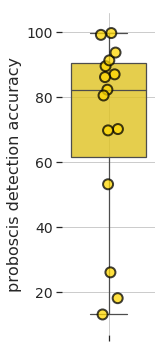

In [36]:
fig, ax1 = plt.subplots(figsize=(2.5, 5))

sns.boxplot(y="accuracy",data = allprint_df, whis=np.inf, ax=ax1, showbox=True,dodge=False, color = '#ffd801',
            meanline=True,showmeans=False, showfliers=True,showcaps=True, linewidth = 1.25)

ax1 = sns.stripplot(y="accuracy", data=allprint_df,ax=ax1,  jitter=True, size = 10, linewidth=2, color = '#ffd801', 
                    marker='o', edgecolor ="black", alpha = 0.75)

b = list(ax1.get_children())

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

# ax1.set_ylim([0,100])
ax1.set_ylabel('proboscis detection accuracy', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

ax1.grid(True)
sns.despine(left=True, bottom=True, right=True)


plt.tight_layout()

In [37]:
#print(pdtabulate(allprint_df))

In [38]:
allflyverif_df = pd.concat(allflyverif_df)
allflyverif_df = allflyverif_df.reset_index(drop = True)

In [39]:
allflyverif_df

,frame,likelihood,diff,hour,frametime,state,true_event,notes,cutoff_diff,hour_index,flyname
0,3883.0,16.514883,NaN,1,2018-07-27 15:14:48,awake,yes,NaN,NaN,15,02_27072018_SponSleep_LFP
1,4691.0,21.469048,808.0,1,2018-07-27 15:15:17,awake,yes,NaN,NaN,15,02_27072018_SponSleep_LFP
2,4784.0,20.287457,93.0,1,2018-07-27 15:15:21,awake,yes,NaN,93.0,15,02_27072018_SponSleep_LFP
3,4870.0,19.715495,86.0,1,2018-07-27 15:15:24,awake,yes,NaN,86.0,15,02_27072018_SponSleep_LFP
4,4934.0,20.417038,64.0,1,2018-07-27 15:15:26,awake,yes,NaN,64.0,15,02_27072018_SponSleep_LFP
...,...,...,...,...,...,...,...,...,...,...,...
4933,110293.0,30.905988,263.0,8,2019-02-20 16:44:55,awake,yes,NaN,263.0,16,21_20022019_SponSleep_LFP
4934,110738.0,31.817816,445.0,8,2019-02-20 16:45:08,awake,yes,NaN,NaN,16,21_20022019_SponSleep_LFP
4935,111809.0,30.659589,1071.0,8,2019-02-20 16:45:39,awake,yes,NaN,NaN,16,21_20022019_SponSleep_LFP
4936,112419.0,26.252487,610.0,8,2019-02-20 16:45:57,awake,yes,NaN,NaN,16,21_20022019_SponSleep_LFP


In [40]:
groupawakemeanval=[]
groupsleepmeanval=[]
groupintransmeanval=[]

In [41]:
overallevents = 0

In [42]:
for indivflyname in flynamelist:
    
    posefiles_dir = inputfolderpath + indivflyname + '/' + 'posetracked_files/'
    posefiledlcname = []
    for name in sorted(glob.glob(posefiles_dir + indivflyname[3:-4] + "*.h5")):
        posefiledlcname.append(name)
        #print(name)
    indivflyverif_df = allflyverif_df.loc[allflyverif_df.flyname == indivflyname,:]
    
    #indivflyverif_df = indivflyverif_df.loc[~np.isnan(indivflyverif_df['diff']),:]
    
    indivflyverif_df = indivflyverif_df.loc[~np.isnan(indivflyverif_df['cutoff_diff']),:]
    
    print('Processing: ', indivflyname, 'with events #', len(indivflyverif_df))
    
    overallevents = overallevents + len(indivflyverif_df)
    
    deviation_awake, deviation_sleep, deviation_intrans = compute_deviations(indivflyverif_df,posefiledlcname)
    
    
    if ((deviation_awake is not None) & (deviation_sleep is not None) ): #& (deviation_intrans is not None)
        deviations_all = [deviation_sleep.values.tolist(),deviation_awake.values.tolist()]
                         #deviation_intrans.values.tolist()
        
        deviations_merged = list(itertools.chain(*deviations_all))
    
        maxval = max(max(deviations_merged))
        minval = min(min(deviations_merged))
    
        deviation_awakenorm = (deviation_awake - minval) / (maxval - minval)
        deviation_df = deviation_awakenorm.T
        awakemeanval = deviation_df.mean()
        groupawakemeanval.append(awakemeanval)
        
        deviation_sleepnorm = (deviation_sleep - minval) / (maxval - minval)
        deviation_df = deviation_sleepnorm.T
        sleepmeanval = deviation_df.mean()
        groupsleepmeanval.append(sleepmeanval)
    
        #deviation_intransnorm = (deviation_intrans - minval) / (maxval - minval)
        #deviation_df = deviation_intransnorm.T
        #intransmeanval = deviation_df.mean()
        #groupintransmeanval.append(intransmeanval)
        
    else:
        print('Skipping: ', indivflyname)

Processing:  02_27072018_SponSleep_LFP with events # 267
Processing:  03_14092018_SponSleep_LFP with events # 259
Processing:  04_17092018_SponSleep_LFP with events # 176
Processing:  06_30102018_SponSleep_LFP with events # 87
Processing:  07_01112018_SponSleep_LFP with events # 22
Processing:  08_03112018_SponSleep_LFP with events # 53
Processing:  09_13112018_SponSleep_LFP with events # 103
Processing:  12_28112018_SponSleep_LFP with events # 169
Processing:  14_11122018_SponSleep_LFP with events # 303
Processing:  16_18122018_SponSleep_LFP with events # 683
Skipping:  16_18122018_SponSleep_LFP
Processing:  17_10012019_SponSleep_LFP with events # 99
Processing:  18_17012019_SponSleep_LFP with events # 211
Processing:  19_22012019_SponSleep_LFP with events # 186
Processing:  21_20022019_SponSleep_LFP with events # 1536


In [43]:
print('True events:          ', len(allflyverif_df))
print('events under cut-off: ', overallevents)

True events:           4938
events under cut-off:  4154


In [44]:
groupawakemeanval = pd.DataFrame(groupawakemeanval)
groupsleepmeanval = pd.DataFrame(groupsleepmeanval)
#groupintransmeanval = pd.DataFrame(groupintransmeanval)

In [45]:
plotawakemeanval = groupawakemeanval.mean()
plotawakesemval = groupawakemeanval.sem()

In [46]:
plotsleepmeanval = groupsleepmeanval.mean()
plotsleepsemval = groupsleepmeanval.sem()

In [47]:
#plotintransmeanval = groupintransmeanval.mean()
#plotintranssemval = groupintransmeanval.sem()

In [48]:
xplotval = range(0,len(np.arange(-framebegin,frameend)))

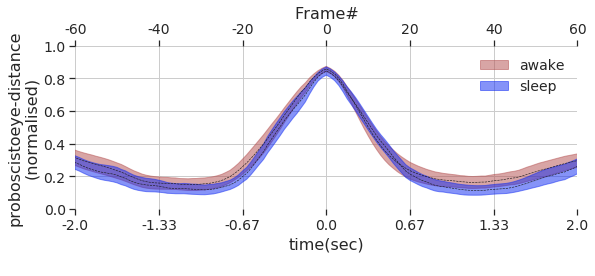

In [49]:
fig, ax1 = plt.subplots(figsize=(9, 3))
ax1.plot(xplotval, plotawakemeanval, 'k--')
plt.fill_between(xplotval, plotawakemeanval-plotawakesemval, plotawakemeanval+plotawakesemval, color = '#b34d4d', 
                 alpha = 0.5, label = 'awake')

ax1.plot(xplotval, plotsleepmeanval, 'k--')
plt.fill_between(xplotval, plotsleepmeanval-plotsleepsemval, plotsleepmeanval+plotsleepsemval, color = '#0d28f2',
                 alpha = 0.5, label = 'sleep')

#ax1.plot(xplotval, plotintransmeanval, 'k--')
#plt.fill_between(xplotval, plotintransmeanval-plotintranssemval, plotintransmeanval+plotintranssemval, 
#                 color = 'magenta', alpha = 0.5, label = 'intrans')

plt.legend(loc="upper right",frameon=False, fontsize=label_fontsize-2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(np.arange(0,len(np.arange(-framebegin,frameend+10)),20))
tickval = np.arange(-framebegin,frameend+10, 20)
ax1.set_xlim(60,180)


plt.ylabel('proboscistoeye-distance\n(normalised)', fontsize=label_fontsize)



ax2 = ax1.twiny()
ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())


ax2.set_xticklabels(np.arange(-framebegin,frameend+10, 20))
ax1.set_xticklabels([np.round((x-120)/30,2) for x in ax1.get_xticks()])

ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

ax1.set_xlabel('time(sec)\n', fontsize=label_fontsize)
ax2.set_xlabel('Frame#', fontsize=label_fontsize)

ax1.grid(True)
sns.despine(left=True, bottom=True, right=True)

plt.box(False)

In [50]:
flyevents_df = pd.concat(flyeventslist)

In [51]:
flyevents_df

,frame,likelihood,diff,hour,frametime,state,true_event,notes,cutoff_diff,hour_index,flyname
0,3883.0,16.514883,NaN,1,2018-07-27 15:14:48,awake,yes,NaN,NaN,15,02_27072018_SponSleep_LFP
1,4691.0,21.469048,808.0,1,2018-07-27 15:15:17,awake,yes,NaN,NaN,15,02_27072018_SponSleep_LFP
2,4784.0,20.287457,93.0,1,2018-07-27 15:15:21,awake,yes,NaN,93.0,15,02_27072018_SponSleep_LFP
3,4870.0,19.715495,86.0,1,2018-07-27 15:15:24,awake,yes,NaN,86.0,15,02_27072018_SponSleep_LFP
4,4934.0,20.417038,64.0,1,2018-07-27 15:15:26,awake,yes,NaN,64.0,15,02_27072018_SponSleep_LFP
...,...,...,...,...,...,...,...,...,...,...,...
1812,110293.0,30.905988,263.0,8,2019-02-20 16:44:55,awake,yes,NaN,263.0,16,21_20022019_SponSleep_LFP
1813,110738.0,31.817816,445.0,8,2019-02-20 16:45:08,awake,yes,NaN,NaN,16,21_20022019_SponSleep_LFP
1814,111809.0,30.659589,1071.0,8,2019-02-20 16:45:39,awake,yes,NaN,NaN,16,21_20022019_SponSleep_LFP
1815,112419.0,26.252487,610.0,8,2019-02-20 16:45:57,awake,yes,NaN,NaN,16,21_20022019_SponSleep_LFP


In [52]:
framediff = flyevents_df['diff']

In [53]:
event_type = flyevents_df['state']
event_type.unique()

array(['awake', 'sleep', 'intrans'], dtype=object)

In [54]:
flyevents_df['frametime']

0       2018-07-27 15:14:48
1       2018-07-27 15:15:17
2       2018-07-27 15:15:21
3       2018-07-27 15:15:24
4       2018-07-27 15:15:26
               ...         
1812    2019-02-20 16:44:55
1813    2019-02-20 16:45:08
1814    2019-02-20 16:45:39
1815    2019-02-20 16:45:57
1816    2019-02-20 16:46:12
Name: frametime, Length: 4938, dtype: object

In [55]:
allprobtimeinterval = (1/30)*framediff
allprobtimeinterval[allprobtimeinterval>= cutoff_time] = np.nan

In [56]:
sum(allprobtimeinterval.notna())

4154

In [57]:
allframeinterval = 30*allprobtimeinterval

In [58]:
awakeprobtimeinterval = allprobtimeinterval[event_type == 'awake']
sleepprobtimeinterval = allprobtimeinterval[event_type == 'sleep']
intransprobtimeinterval = allprobtimeinterval[event_type == 'intrans']

In [59]:
print('all proboscis interval(sec):    ', 'min:', np.round(np.min(allprobtimeinterval),2), 
                                          ',max:', np.round(np.max(allprobtimeinterval),2))
print('awake proboscis interval(sec):  ', 'min:', np.round(np.min(awakeprobtimeinterval),2),
                                          ',max:', np.round(np.max(awakeprobtimeinterval),2))
print('sleep proboscis interval(sec):  ', 'min:', np.round(np.min(sleepprobtimeinterval),2),
                                          ',max:', np.round(np.max(sleepprobtimeinterval),2))
print('intrans proboscis interval(sec):', 'min:', np.round(np.min(intransprobtimeinterval),2),
                                         ',max:', np.round(np.max(intransprobtimeinterval),2))

all proboscis interval(sec):     min: 1.03 ,max: 9.97
awake proboscis interval(sec):   min: 1.03 ,max: 9.97
sleep proboscis interval(sec):   min: 1.6 ,max: 9.9
intrans proboscis interval(sec): min: 1.67 ,max: 6.2


In [60]:
print('all proboscis interval -- 95th percentile(sec) :', 
      np.round(np.percentile(allprobtimeinterval[~np.isnan(allprobtimeinterval)], 5),2))
print('all proboscis interval -- 95th percentile(frame) :', 
      np.round(np.percentile(allframeinterval[~np.isnan(allframeinterval)], 5),2))

all proboscis interval -- 95th percentile(sec) : 1.8
all proboscis interval -- 95th percentile(frame) : 54.0


Text(0.5, 0.98, 'inter proboscis interval')

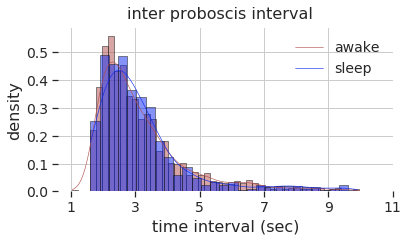

In [61]:
fig = plt.figure(figsize=(6, 3))
gs_main = gridspec.GridSpec(1, 1,width_ratios=[4])
gs_main.update(wspace=0.25, hspace=0.2)


gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax2 = fig.add_subplot(gs[0])

ax2 = sns.histplot(awakeprobtimeinterval, stat = 'density', kde = True, ax = ax2,  
                  color = '#b34d4d',edgecolor="k", alpha = 0.5, linewidth=0.5)
ax2 = sns.histplot(sleepprobtimeinterval, stat = 'density', kde = True, ax = ax2,
                  color = '#0d28f2',edgecolor="k", alpha = 0.5,linewidth=0.5)

ax2.grid(True)
ax2.set_ylabel('density', fontsize=label_fontsize)
ax2.set_xlabel('time interval (sec)', fontsize=label_fontsize)
ax2.set_xticks([1, 3, 5, 7, 9, 11])
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax2.legend(labels = ['awake', 'sleep'], prop={'size': label_fontsize-2},frameon=False)

sns.despine(left=True, bottom=True, right=True)

plt.suptitle('inter proboscis interval',fontsize=label_fontsize)